In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from time import time

In [3]:
transform = transforms.ToTensor()

trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform) #carrega o set de treinamento
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) #cria um buffer para pegar dados por partes

valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform) #carrega o set de validação
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True) #cria um buffer para pegar dados por partes

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



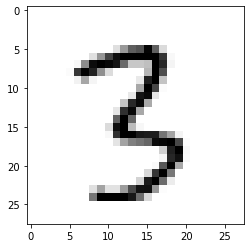

In [4]:
dataiter = iter(trainloader)  #verificar se está acessando as imagens
imagens, etiquetas = dataiter.next()
plt.imshow(imagens[0].numpy().squeeze(), cmap = 'gray_r')

In [5]:
print(imagens[0].shape) #verificar as dimensões do tensor de cada imagem
print(etiquetas[0].shape) #verificar as dimensões do tensor de cada etiqueta

torch.Size([1, 28, 28])
torch.Size([])


In [12]:
print(imagens[0])
print(etiquetas[0])

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [6]:
#carregar modelo de rede de https://keras.io/api/applications/inceptionv3/
class Modelo(nn.Module):

  def __init__(self):
    super(Modelo,self).__init__()
    self.linear1 = nn.Linear(28*28, 128) #camada de entrada, 728 neuronios ligados a 128
    self.linear2 = nn.Linear(128, 64) #camada interna 1, 128 neuronios ligados a 64
    self.linear3 = nn.Linear(64, 10) #camada interna 2, 64 neuronios ligados a 10
    #nao é necessaro definir a camada de saida, precisamos do output da camada 2

  def forward(self, X):
    X = F.relu(self.linear1(X)) #funçao de ativação da camada de entrada para a camada interna 1
    X = F.relu(self.linear2(X)) #funçao de ativação da camada interna 1 para a camada interna 2
    X = self.linear3(X) #funçao de ativação da camada interna 2 para a camada de saida, neste caso f(x) = x
    return F.log_softmax(X,dim=1) #dados utilizados para calcular a perda



In [20]:
def treino(modelo, trainloader, device):
    
    otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) # define a polítca de atualização dos pesos e da bias
    inicio = time() # timer para sabermos quanto tempo levou o treino
    
    criterio = nn.NLLLoss() # definindo o criterio para calcular a perda
    EPOCHS = 30 # numero de epochs que o algoritmo rodará
    modelo.train() # ativando o modo de treinamento do modelo

    for epoch in range(EPOCHS):
        perda_acumulada = 0 # inicialização da perda acumulada da epoch em questão
        
        for imagens, etiquetas in trainloader:
            
            imagens = imagens.view(imagens.shape[0], -1) # convertendo as imagens para  "vetores" de 28*28 casas para ficarem compatíveis com a camada de entrada
            otimizador.zero_grad() # zerando os gradientes por conta do ciclo anterior
            
            output = modelo(imagens.to(device)) # colocando os dados no modelo
            perda_instantanea = criterio(output, etiquetas.to(device)) # calculando a perda da epoch em questão
            
            perda_instantanea.backward() # back propagation a partir da perda
            
            otimizador.step() # atualizando os pesos e a bias
            
            perda_acumulada += perda_instantanea.item() # atualização da perda acumulada
        
        
        else:
            print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))
    print("\nTempo de treino (em minutos) =",(time()-inicio)/60)

In [18]:
def validacao(modelo, valloader, device):
  conta_corretas, conta_todas = 0, 0
  
  for imagens, etiquetas in valloader:
    for i in range(len(etiquetas)):
      img = imagens[i].view(1, 784) #desativar o autograda para acelerar a validacao
      
      with torch.no_grad():
        logps = modelo(img.to(device)) #output do modelo em escala logaritmica

      ps = torch.exp(logps) #converte output para escala normal (lembrando que é tensor)
      probab = list(ps.cpu().numpy()[0]) 

      etiqueta_pred = probab.index(max(probab)) #converter tensor em  um numero, no caso, o numero que o modelo previu 
      etiqueta_certa = etiquetas.numpy()[i]

      if (etiqueta_certa == etiqueta_pred): #compara certa com previsto
        conta_corretas += 1 
      conta_todas += 1

  print('Total de imagens testadas = ', conta_todas)
  print('Precisão do modelo = {}%'.format(conta_corretas*100/conta_todas))



In [21]:
modelo = Modelo()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

In [22]:
treino(modelo,trainloader,device)

Epoch 1 - Perda resultante: 1.1695887371262252
Epoch 2 - Perda resultante: 0.3801384708647535
Epoch 3 - Perda resultante: 0.30939880976957806
Epoch 4 - Perda resultante: 0.2699448160652413
Epoch 5 - Perda resultante: 0.23955874005630454
Epoch 6 - Perda resultante: 0.21410656876877934
Epoch 7 - Perda resultante: 0.1926016066549048
Epoch 8 - Perda resultante: 0.17428837195118227
Epoch 9 - Perda resultante: 0.15947338700818736
Epoch 10 - Perda resultante: 0.14608678649038648
Epoch 11 - Perda resultante: 0.13367096586291916
Epoch 12 - Perda resultante: 0.12400748654564561
Epoch 13 - Perda resultante: 0.114964975138455
Epoch 14 - Perda resultante: 0.10697311866802098
Epoch 15 - Perda resultante: 0.09970399517037754
Epoch 16 - Perda resultante: 0.09320042336752801
Epoch 17 - Perda resultante: 0.08725043602271883
Epoch 18 - Perda resultante: 0.08231257412558807
Epoch 19 - Perda resultante: 0.07740625112242043
Epoch 20 - Perda resultante: 0.07301494188811272
Epoch 21 - Perda resultante: 0.0688

In [23]:
validacao(modelo, valloader, device)

Total de imagens testadas =  10000
Precisão do modelo = 97.67%
